In [9]:
import numpy as np
import torch
import matplotlib.pyplot as plt
device = 0
np.random.seed(0)
torch.random.manual_seed(0)

## Difference from tensorflow implementation(so far)
1. Time step is not input to neural net
2. Initial state is initialized randomly and learnable, instead of zero

In [10]:
def generate_left_prob(held_out_range = [[0.1, 0.2], [0.3, 0.4]]):
    def check_heldout(left_prob):
        inrange = False
        for low, high in held_out_range:
            if left_prob>low and left_prob<high:
                inrange = True
        return inrange
    left_prob = -1
    while left_prob<0 or left_prob>0.5 or check_heldout(left_prob):
        left_prob = np.random.uniform(0, 0.5)
    return left_prob

def get_trial(current_state, left_prob, action): # get next trial after action
    assert 0<=left_prob and left_prob<=0.5, "probability out of range"
    right_prob = 0.5-left_prob
    current_state = current_state.copy()
    current_state[action] = 0
    if np.random.uniform()<left_prob:
        current_state[0] = 1
    if np.random.uniform()<right_prob:
        current_state[1] = 1
    return current_state

def discount(rewards, discount_f):
    cumsum = 0
    value_targets = []
    for i in range(0, len(rewards)):
        index = -i-1 # starting at -1, ending at 0
        cumsum = cumsum*discount_f+rewards[index]
        value_targets = [cumsum]+value_targets
    return value_targets

In [11]:
minimum = 30
for i in range(10000):
    minimum = min(minimum, np.random.uniform())

In [12]:
class A3C(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.init_h = torch.nn.Parameter(torch.zeros(1, 48)).cuda(device)
        self.init_c = torch.nn.Parameter(torch.zeros(1, 48)).cuda(device)
        self.lstm = torch.nn.LSTMCell(3, 48)
        self.action_head = torch.nn.Linear(48, 2)
        self.value_head = torch.nn.Linear(48, 1)
    def forward(self, prev_action, prev_reward, lstm_state):
        input_vec = torch.zeros(3).cuda(device)
        if prev_action!=-1: # if not first trial
            input_vec[prev_action] = 1
        input_vec[2] = prev_reward
        if lstm_state == None:
            h, c = self.lstm(input_vec[None, ...], (self.init_h, self.init_c))
        else:
            h, c = self.lstm(input_vec[None, ...], lstm_state)
        action_probs = self.action_head(h).softmax(1).clamp(min = 1e-8)
        value = self.value_head(h)
        return action_probs, value, (h, c)

agent = A3C().cuda(device)
optimizer = torch.optim.RMSprop(agent.parameters(), 0.007)

In [15]:
# actions = [a0, a1, a2, ...., aT]
# value_preds = [V0, V1, V2, ...., VT]
# rewards = [r0, r1, r2, ..... , rT]
# value_target = []
def run_block(block_num, train = True, bv = 0.05, be = 0.05, discount_f = 0.75):
    num_trials = np.random.randint(50, 101)
    left_prob = generate_left_prob()
    state = get_trial([0, 0], left_prob, 0)
    action = -1
    reward = 0.25
    lstm_state = None
    value_preds = []
    rewards = []
    actions = []
    policies = []
    for trial_num in range(num_trials):
        action_probs, value_pred, lstm_state = agent(action, reward, lstm_state)
        action = np.random.choice([0, 1], p = action_probs.detach().cpu().numpy().flatten())
        reward = state[action]
        policies.append(action_probs[0])
        value_preds.append(value_pred)
        actions.append(action)
        rewards.append(reward)
        state = get_trial(state, left_prob, action)
    value_targets = torch.Tensor(discount(rewards, discount_f)).cuda(device)
    value_preds = torch.Tensor(value_preds).cuda(device)
    policies = torch.stack(policies, dim = 0)
    actions = torch.Tensor(actions).long()
    advantage = (value_targets - value_preds).detach()
    if train:
        value_loss = torch.nn.MSELoss()(value_preds, value_targets)
        policy_loss = -torch.mean(torch.log(policies[torch.arange(policies.shape[0]), actions])*advantage)
        entropy_loss = torch.mean(torch.log(policies)*policies)
        loss = policy_loss + value_loss*bv + entropy_loss*be
        loss.backward()
    print('trial block:', block_num, 'reward:', sum(rewards)/num_trials)
    
    # examine actions
    actions = actions.numpy()[int(num_trials/3*1):]
    right_actions = sum(actions)
    left_actions = len(actions)-right_actions
    rewards = np.array(rewards)[int(num_trials/3*1):]
    left_rewards = np.sum(rewards[actions == 0])
    right_rewards = np.sum(rewards[actions == 1])
    return left_actions, right_actions, left_rewards, right_rewards

In [16]:
for block_num in range(10000):
    left_actions, right_actions, left_rewards, right_rewards = run_block(block_num)
    if block_num%100 == 99:
        optimizer.step()
        optimizer.zero_grad()

trial block: 0 reward: 0.3125
trial block: 1 reward: 0.36486486486486486
trial block: 2 reward: 0.37755102040816324
trial block: 3 reward: 0.22388059701492538
trial block: 4 reward: 0.35135135135135137
trial block: 5 reward: 0.3018867924528302
trial block: 6 reward: 0.3617021276595745
trial block: 7 reward: 0.46808510638297873
trial block: 8 reward: 0.3220338983050847
trial block: 9 reward: 0.33766233766233766
trial block: 10 reward: 0.46153846153846156
trial block: 11 reward: 0.30337078651685395
trial block: 12 reward: 0.35526315789473684
trial block: 13 reward: 0.37254901960784315
trial block: 14 reward: 0.35294117647058826
trial block: 15 reward: 0.45454545454545453
trial block: 16 reward: 0.3333333333333333
trial block: 17 reward: 0.3614457831325301
trial block: 18 reward: 0.4339622641509434
trial block: 19 reward: 0.3793103448275862
trial block: 20 reward: 0.3368421052631579
trial block: 21 reward: 0.3472222222222222
trial block: 22 reward: 0.38
trial block: 23 reward: 0.5
trial b

trial block: 195 reward: 0.19387755102040816
trial block: 196 reward: 0.2682926829268293
trial block: 197 reward: 0.2604166666666667
trial block: 198 reward: 0.19718309859154928
trial block: 199 reward: 0.15384615384615385
trial block: 200 reward: 0.45263157894736844
trial block: 201 reward: 0.3870967741935484
trial block: 202 reward: 0.4642857142857143
trial block: 203 reward: 0.29411764705882354
trial block: 204 reward: 0.3287671232876712
trial block: 205 reward: 0.4
trial block: 206 reward: 0.39344262295081966
trial block: 207 reward: 0.4186046511627907
trial block: 208 reward: 0.39080459770114945
trial block: 209 reward: 0.3333333333333333
trial block: 210 reward: 0.40540540540540543
trial block: 211 reward: 0.4
trial block: 212 reward: 0.36486486486486486
trial block: 213 reward: 0.37735849056603776
trial block: 214 reward: 0.3484848484848485
trial block: 215 reward: 0.34545454545454546
trial block: 216 reward: 0.358974358974359
trial block: 217 reward: 0.5
trial block: 218 reward

trial block: 387 reward: 0.3409090909090909
trial block: 388 reward: 0.35
trial block: 389 reward: 0.31868131868131866
trial block: 390 reward: 0.3384615384615385
trial block: 391 reward: 0.35294117647058826
trial block: 392 reward: 0.35294117647058826
trial block: 393 reward: 0.3620689655172414
trial block: 394 reward: 0.48
trial block: 395 reward: 0.42391304347826086
trial block: 396 reward: 0.46153846153846156
trial block: 397 reward: 0.3225806451612903
trial block: 398 reward: 0.4246575342465753
trial block: 399 reward: 0.3333333333333333
trial block: 400 reward: 0.30952380952380953
trial block: 401 reward: 0.3076923076923077
trial block: 402 reward: 0.4166666666666667
trial block: 403 reward: 0.35
trial block: 404 reward: 0.3448275862068966
trial block: 405 reward: 0.4166666666666667
trial block: 406 reward: 0.39705882352941174
trial block: 407 reward: 0.3711340206185567
trial block: 408 reward: 0.42424242424242425
trial block: 409 reward: 0.3582089552238806
trial block: 410 rewar

trial block: 579 reward: 0.40860215053763443
trial block: 580 reward: 0.35714285714285715
trial block: 581 reward: 0.37254901960784315
trial block: 582 reward: 0.29411764705882354
trial block: 583 reward: 0.4444444444444444
trial block: 584 reward: 0.37755102040816324
trial block: 585 reward: 0.3870967741935484
trial block: 586 reward: 0.4177215189873418
trial block: 587 reward: 0.4461538461538462
trial block: 588 reward: 0.36046511627906974
trial block: 589 reward: 0.3870967741935484
trial block: 590 reward: 0.34328358208955223
trial block: 591 reward: 0.3888888888888889
trial block: 592 reward: 0.47435897435897434
trial block: 593 reward: 0.3645833333333333
trial block: 594 reward: 0.40476190476190477
trial block: 595 reward: 0.4533333333333333
trial block: 596 reward: 0.39285714285714285
trial block: 597 reward: 0.417910447761194
trial block: 598 reward: 0.3142857142857143
trial block: 599 reward: 0.4
trial block: 600 reward: 0.3424657534246575
trial block: 601 reward: 0.42
trial bl

trial block: 773 reward: 0.3898305084745763
trial block: 774 reward: 0.2840909090909091
trial block: 775 reward: 0.44086021505376344
trial block: 776 reward: 0.4915254237288136
trial block: 777 reward: 0.3870967741935484
trial block: 778 reward: 0.43859649122807015
trial block: 779 reward: 0.3469387755102041
trial block: 780 reward: 0.4431818181818182
trial block: 781 reward: 0.4444444444444444
trial block: 782 reward: 0.3448275862068966
trial block: 783 reward: 0.48
trial block: 784 reward: 0.3333333333333333
trial block: 785 reward: 0.4838709677419355
trial block: 786 reward: 0.39325842696629215
trial block: 787 reward: 0.390625
trial block: 788 reward: 0.4262295081967213
trial block: 789 reward: 0.33766233766233766
trial block: 790 reward: 0.24731182795698925
trial block: 791 reward: 0.359375
trial block: 792 reward: 0.37209302325581395
trial block: 793 reward: 0.32051282051282054
trial block: 794 reward: 0.4098360655737705
trial block: 795 reward: 0.47619047619047616
trial block: 7

trial block: 969 reward: 0.38271604938271603
trial block: 970 reward: 0.3508771929824561
trial block: 971 reward: 0.3048780487804878
trial block: 972 reward: 0.43
trial block: 973 reward: 0.3829787234042553
trial block: 974 reward: 0.43478260869565216
trial block: 975 reward: 0.41333333333333333
trial block: 976 reward: 0.4044943820224719
trial block: 977 reward: 0.4367816091954023
trial block: 978 reward: 0.32
trial block: 979 reward: 0.42528735632183906
trial block: 980 reward: 0.44
trial block: 981 reward: 0.4044943820224719
trial block: 982 reward: 0.3333333333333333
trial block: 983 reward: 0.4057971014492754
trial block: 984 reward: 0.3
trial block: 985 reward: 0.35714285714285715
trial block: 986 reward: 0.36363636363636365
trial block: 987 reward: 0.33962264150943394
trial block: 988 reward: 0.4827586206896552
trial block: 989 reward: 0.3783783783783784
trial block: 990 reward: 0.36
trial block: 991 reward: 0.3684210526315789
trial block: 992 reward: 0.34615384615384615
trial b

trial block: 1160 reward: 0.3979591836734694
trial block: 1161 reward: 0.3684210526315789
trial block: 1162 reward: 0.35802469135802467
trial block: 1163 reward: 0.4166666666666667
trial block: 1164 reward: 0.3541666666666667
trial block: 1165 reward: 0.4024390243902439
trial block: 1166 reward: 0.4090909090909091
trial block: 1167 reward: 0.46835443037974683
trial block: 1168 reward: 0.410958904109589
trial block: 1169 reward: 0.3333333333333333
trial block: 1170 reward: 0.38571428571428573
trial block: 1171 reward: 0.43478260869565216
trial block: 1172 reward: 0.4307692307692308
trial block: 1173 reward: 0.40298507462686567
trial block: 1174 reward: 0.3522727272727273
trial block: 1175 reward: 0.3375
trial block: 1176 reward: 0.4375
trial block: 1177 reward: 0.37333333333333335
trial block: 1178 reward: 0.36923076923076925
trial block: 1179 reward: 0.4745762711864407
trial block: 1180 reward: 0.3894736842105263
trial block: 1181 reward: 0.38372093023255816
trial block: 1182 reward: 0

trial block: 1350 reward: 0.3855421686746988
trial block: 1351 reward: 0.4166666666666667
trial block: 1352 reward: 0.4246575342465753
trial block: 1353 reward: 0.43902439024390244
trial block: 1354 reward: 0.39285714285714285
trial block: 1355 reward: 0.42857142857142855
trial block: 1356 reward: 0.43333333333333335
trial block: 1357 reward: 0.4626865671641791
trial block: 1358 reward: 0.37662337662337664
trial block: 1359 reward: 0.375
trial block: 1360 reward: 0.4189189189189189
trial block: 1361 reward: 0.3939393939393939
trial block: 1362 reward: 0.41509433962264153
trial block: 1363 reward: 0.35064935064935066
trial block: 1364 reward: 0.379746835443038
trial block: 1365 reward: 0.4090909090909091
trial block: 1366 reward: 0.3770491803278688
trial block: 1367 reward: 0.38636363636363635
trial block: 1368 reward: 0.41509433962264153
trial block: 1369 reward: 0.36363636363636365
trial block: 1370 reward: 0.3717948717948718
trial block: 1371 reward: 0.3333333333333333
trial block: 1

trial block: 1540 reward: 0.3880597014925373
trial block: 1541 reward: 0.38666666666666666
trial block: 1542 reward: 0.32222222222222224
trial block: 1543 reward: 0.32989690721649484
trial block: 1544 reward: 0.4074074074074074
trial block: 1545 reward: 0.35802469135802467
trial block: 1546 reward: 0.3384615384615385
trial block: 1547 reward: 0.36
trial block: 1548 reward: 0.40860215053763443
trial block: 1549 reward: 0.46
trial block: 1550 reward: 0.4639175257731959
trial block: 1551 reward: 0.43902439024390244
trial block: 1552 reward: 0.39285714285714285
trial block: 1553 reward: 0.3125
trial block: 1554 reward: 0.3898305084745763
trial block: 1555 reward: 0.45
trial block: 1556 reward: 0.4375
trial block: 1557 reward: 0.43037974683544306
trial block: 1558 reward: 0.47560975609756095
trial block: 1559 reward: 0.3835616438356164
trial block: 1560 reward: 0.4393939393939394
trial block: 1561 reward: 0.5185185185185185
trial block: 1562 reward: 0.35185185185185186
trial block: 1563 rew

trial block: 1730 reward: 0.3763440860215054
trial block: 1731 reward: 0.36538461538461536
trial block: 1732 reward: 0.3763440860215054
trial block: 1733 reward: 0.37681159420289856
trial block: 1734 reward: 0.4166666666666667
trial block: 1735 reward: 0.3137254901960784
trial block: 1736 reward: 0.3625
trial block: 1737 reward: 0.4
trial block: 1738 reward: 0.36904761904761907
trial block: 1739 reward: 0.375
trial block: 1740 reward: 0.3939393939393939
trial block: 1741 reward: 0.47540983606557374
trial block: 1742 reward: 0.41935483870967744
trial block: 1743 reward: 0.4423076923076923
trial block: 1744 reward: 0.36923076923076925
trial block: 1745 reward: 0.3684210526315789
trial block: 1746 reward: 0.46774193548387094
trial block: 1747 reward: 0.391304347826087
trial block: 1748 reward: 0.38333333333333336
trial block: 1749 reward: 0.5070422535211268
trial block: 1750 reward: 0.4574468085106383
trial block: 1751 reward: 0.3582089552238806
trial block: 1752 reward: 0.458333333333333

trial block: 1916 reward: 0.3402061855670103
trial block: 1917 reward: 0.34210526315789475
trial block: 1918 reward: 0.43529411764705883
trial block: 1919 reward: 0.40425531914893614
trial block: 1920 reward: 0.3956043956043956
trial block: 1921 reward: 0.41935483870967744
trial block: 1922 reward: 0.43661971830985913
trial block: 1923 reward: 0.4533333333333333
trial block: 1924 reward: 0.5
trial block: 1925 reward: 0.37037037037037035
trial block: 1926 reward: 0.4222222222222222
trial block: 1927 reward: 0.3854166666666667
trial block: 1928 reward: 0.35
trial block: 1929 reward: 0.48
trial block: 1930 reward: 0.41414141414141414
trial block: 1931 reward: 0.5245901639344263
trial block: 1932 reward: 0.43157894736842106
trial block: 1933 reward: 0.3902439024390244
trial block: 1934 reward: 0.5
trial block: 1935 reward: 0.43333333333333335
trial block: 1936 reward: 0.5087719298245614
trial block: 1937 reward: 0.4329896907216495
trial block: 1938 reward: 0.32558139534883723
trial block: 

trial block: 2108 reward: 0.35802469135802467
trial block: 2109 reward: 0.4105263157894737
trial block: 2110 reward: 0.31343283582089554
trial block: 2111 reward: 0.5
trial block: 2112 reward: 0.42028985507246375
trial block: 2113 reward: 0.23076923076923078
trial block: 2114 reward: 0.39655172413793105
trial block: 2115 reward: 0.16129032258064516
trial block: 2116 reward: 0.4262295081967213
trial block: 2117 reward: 0.2839506172839506
trial block: 2118 reward: 0.5576923076923077
trial block: 2119 reward: 0.34375
trial block: 2120 reward: 0.12121212121212122
trial block: 2121 reward: 0.21839080459770116
trial block: 2122 reward: 0.16483516483516483
trial block: 2123 reward: 0.5116279069767442
trial block: 2124 reward: 0.07058823529411765
trial block: 2125 reward: 0.1111111111111111
trial block: 2126 reward: 0.43209876543209874
trial block: 2127 reward: 0.25
trial block: 2128 reward: 0.17333333333333334
trial block: 2129 reward: 0.4868421052631579
trial block: 2130 reward: 0.6164383561

trial block: 2296 reward: 0.38372093023255816
trial block: 2297 reward: 0.2804878048780488
trial block: 2298 reward: 0.43529411764705883
trial block: 2299 reward: 0.3684210526315789
trial block: 2300 reward: 0.41
trial block: 2301 reward: 0.47619047619047616
trial block: 2302 reward: 0.4044943820224719
trial block: 2303 reward: 0.28
trial block: 2304 reward: 0.49295774647887325
trial block: 2305 reward: 0.5189873417721519
trial block: 2306 reward: 0.3977272727272727
trial block: 2307 reward: 0.45614035087719296
trial block: 2308 reward: 0.3717948717948718
trial block: 2309 reward: 0.4745762711864407
trial block: 2310 reward: 0.41304347826086957
trial block: 2311 reward: 0.45901639344262296
trial block: 2312 reward: 0.3684210526315789
trial block: 2313 reward: 0.34065934065934067
trial block: 2314 reward: 0.4146341463414634
trial block: 2315 reward: 0.32857142857142857
trial block: 2316 reward: 0.46835443037974683
trial block: 2317 reward: 0.3939393939393939
trial block: 2318 reward: 0.

trial block: 2486 reward: 0.42857142857142855
trial block: 2487 reward: 0.36065573770491804
trial block: 2488 reward: 0.4528301886792453
trial block: 2489 reward: 0.5740740740740741
trial block: 2490 reward: 0.375
trial block: 2491 reward: 0.3968253968253968
trial block: 2492 reward: 0.3978494623655914
trial block: 2493 reward: 0.40816326530612246
trial block: 2494 reward: 0.3870967741935484
trial block: 2495 reward: 0.4431818181818182
trial block: 2496 reward: 0.4891304347826087
trial block: 2497 reward: 0.5
trial block: 2498 reward: 0.41379310344827586
trial block: 2499 reward: 0.36363636363636365
trial block: 2500 reward: 0.42105263157894735
trial block: 2501 reward: 0.5357142857142857
trial block: 2502 reward: 0.3522727272727273
trial block: 2503 reward: 0.36363636363636365
trial block: 2504 reward: 0.3548387096774194
trial block: 2505 reward: 0.37037037037037035
trial block: 2506 reward: 0.4148936170212766
trial block: 2507 reward: 0.4166666666666667
trial block: 2508 reward: 0.35

trial block: 2674 reward: 0.4473684210526316
trial block: 2675 reward: 0.38144329896907214
trial block: 2676 reward: 0.47368421052631576
trial block: 2677 reward: 0.4186046511627907
trial block: 2678 reward: 0.34831460674157305
trial block: 2679 reward: 0.40425531914893614
trial block: 2680 reward: 0.34408602150537637
trial block: 2681 reward: 0.5111111111111111
trial block: 2682 reward: 0.40425531914893614
trial block: 2683 reward: 0.49019607843137253
trial block: 2684 reward: 0.38666666666666666
trial block: 2685 reward: 0.367816091954023
trial block: 2686 reward: 0.421875
trial block: 2687 reward: 0.4888888888888889
trial block: 2688 reward: 0.3382352941176471
trial block: 2689 reward: 0.42028985507246375
trial block: 2690 reward: 0.42857142857142855
trial block: 2691 reward: 0.3484848484848485
trial block: 2692 reward: 0.34523809523809523
trial block: 2693 reward: 0.4166666666666667
trial block: 2694 reward: 0.2682926829268293
trial block: 2695 reward: 0.41935483870967744
trial blo

trial block: 2865 reward: 0.3163265306122449
trial block: 2866 reward: 0.46153846153846156
trial block: 2867 reward: 0.4142857142857143
trial block: 2868 reward: 0.3939393939393939
trial block: 2869 reward: 0.42857142857142855
trial block: 2870 reward: 0.2608695652173913
trial block: 2871 reward: 0.4
trial block: 2872 reward: 0.3902439024390244
trial block: 2873 reward: 0.2807017543859649
trial block: 2874 reward: 0.41333333333333333
trial block: 2875 reward: 0.36046511627906974
trial block: 2876 reward: 0.3181818181818182
trial block: 2877 reward: 0.3582089552238806
trial block: 2878 reward: 0.3617021276595745
trial block: 2879 reward: 0.4111111111111111
trial block: 2880 reward: 0.3584905660377358
trial block: 2881 reward: 0.3090909090909091
trial block: 2882 reward: 0.38666666666666666
trial block: 2883 reward: 0.36363636363636365
trial block: 2884 reward: 0.35714285714285715
trial block: 2885 reward: 0.2875
trial block: 2886 reward: 0.3541666666666667
trial block: 2887 reward: 0.35

trial block: 3054 reward: 0.3698630136986301
trial block: 3055 reward: 0.32941176470588235
trial block: 3056 reward: 0.43010752688172044
trial block: 3057 reward: 0.43820224719101125
trial block: 3058 reward: 0.4444444444444444
trial block: 3059 reward: 0.41379310344827586
trial block: 3060 reward: 0.40229885057471265
trial block: 3061 reward: 0.3838383838383838
trial block: 3062 reward: 0.3548387096774194
trial block: 3063 reward: 0.5064935064935064
trial block: 3064 reward: 0.42105263157894735
trial block: 3065 reward: 0.3888888888888889
trial block: 3066 reward: 0.3333333333333333
trial block: 3067 reward: 0.42168674698795183
trial block: 3068 reward: 0.52
trial block: 3069 reward: 0.35714285714285715
trial block: 3070 reward: 0.4246575342465753
trial block: 3071 reward: 0.35714285714285715
trial block: 3072 reward: 0.42592592592592593
trial block: 3073 reward: 0.3838383838383838
trial block: 3074 reward: 0.36231884057971014
trial block: 3075 reward: 0.3764705882352941
trial block: 

trial block: 3242 reward: 0.3484848484848485
trial block: 3243 reward: 0.2753623188405797
trial block: 3244 reward: 0.43157894736842106
trial block: 3245 reward: 0.38144329896907214
trial block: 3246 reward: 0.4574468085106383
trial block: 3247 reward: 0.4423076923076923
trial block: 3248 reward: 0.375
trial block: 3249 reward: 0.47959183673469385
trial block: 3250 reward: 0.3888888888888889
trial block: 3251 reward: 0.39285714285714285
trial block: 3252 reward: 0.36082474226804123
trial block: 3253 reward: 0.3793103448275862
trial block: 3254 reward: 0.35106382978723405
trial block: 3255 reward: 0.379746835443038
trial block: 3256 reward: 0.40425531914893614
trial block: 3257 reward: 0.4
trial block: 3258 reward: 0.4470588235294118
trial block: 3259 reward: 0.3409090909090909
trial block: 3260 reward: 0.3977272727272727
trial block: 3261 reward: 0.36619718309859156
trial block: 3262 reward: 0.2702702702702703
trial block: 3263 reward: 0.3939393939393939
trial block: 3264 reward: 0.415

trial block: 3432 reward: 0.3508771929824561
trial block: 3433 reward: 0.3870967741935484
trial block: 3434 reward: 0.3448275862068966
trial block: 3435 reward: 0.41836734693877553
trial block: 3436 reward: 0.43529411764705883
trial block: 3437 reward: 0.375
trial block: 3438 reward: 0.425
trial block: 3439 reward: 0.410958904109589
trial block: 3440 reward: 0.43333333333333335
trial block: 3441 reward: 0.2830188679245283
trial block: 3442 reward: 0.43478260869565216
trial block: 3443 reward: 0.4105263157894737
trial block: 3444 reward: 0.45588235294117646
trial block: 3445 reward: 0.35714285714285715
trial block: 3446 reward: 0.33
trial block: 3447 reward: 0.35185185185185186
trial block: 3448 reward: 0.45348837209302323
trial block: 3449 reward: 0.34
trial block: 3450 reward: 0.3918918918918919
trial block: 3451 reward: 0.49295774647887325
trial block: 3452 reward: 0.39285714285714285
trial block: 3453 reward: 0.3870967741935484
trial block: 3454 reward: 0.37735849056603776
trial blo

trial block: 3620 reward: 0.02040816326530612
trial block: 3621 reward: 0.07216494845360824
trial block: 3622 reward: 0.49411764705882355
trial block: 3623 reward: 0.27419354838709675
trial block: 3624 reward: 0.21951219512195122
trial block: 3625 reward: 0.04819277108433735
trial block: 3626 reward: 0.06
trial block: 3627 reward: 0.5151515151515151
trial block: 3628 reward: 0.25
trial block: 3629 reward: 0.2073170731707317
trial block: 3630 reward: 0.2828282828282828
trial block: 3631 reward: 0.25287356321839083
trial block: 3632 reward: 0.37662337662337664
trial block: 3633 reward: 0.2077922077922078
trial block: 3634 reward: 0.42105263157894735
trial block: 3635 reward: 0.5357142857142857
trial block: 3636 reward: 0.24
trial block: 3637 reward: 0.28
trial block: 3638 reward: 0.058823529411764705
trial block: 3639 reward: 0.05660377358490566
trial block: 3640 reward: 0.15384615384615385
trial block: 3641 reward: 0.32954545454545453
trial block: 3642 reward: 0.3068181818181818
trial b

trial block: 3806 reward: 0.4536082474226804
trial block: 3807 reward: 0.46875
trial block: 3808 reward: 0.43243243243243246
trial block: 3809 reward: 0.35365853658536583
trial block: 3810 reward: 0.3953488372093023
trial block: 3811 reward: 0.48863636363636365
trial block: 3812 reward: 0.3055555555555556
trial block: 3813 reward: 0.37894736842105264
trial block: 3814 reward: 0.3707865168539326
trial block: 3815 reward: 0.3384615384615385
trial block: 3816 reward: 0.3723404255319149
trial block: 3817 reward: 0.3116883116883117
trial block: 3818 reward: 0.3770491803278688
trial block: 3819 reward: 0.42028985507246375
trial block: 3820 reward: 0.39759036144578314
trial block: 3821 reward: 0.3333333333333333
trial block: 3822 reward: 0.36538461538461536
trial block: 3823 reward: 0.34782608695652173
trial block: 3824 reward: 0.2711864406779661
trial block: 3825 reward: 0.3728813559322034
trial block: 3826 reward: 0.30158730158730157
trial block: 3827 reward: 0.3548387096774194
trial block:

trial block: 3996 reward: 0.5892857142857143
trial block: 3997 reward: 0.36
trial block: 3998 reward: 0.4155844155844156
trial block: 3999 reward: 0.35789473684210527
trial block: 4000 reward: 0.5294117647058824
trial block: 4001 reward: 0.45454545454545453
trial block: 4002 reward: 0.4084507042253521
trial block: 4003 reward: 0.42028985507246375
trial block: 4004 reward: 0.375
trial block: 4005 reward: 0.3888888888888889
trial block: 4006 reward: 0.4
trial block: 4007 reward: 0.38596491228070173
trial block: 4008 reward: 0.3780487804878049
trial block: 4009 reward: 0.3709677419354839
trial block: 4010 reward: 0.36764705882352944
trial block: 4011 reward: 0.4675324675324675
trial block: 4012 reward: 0.4594594594594595
trial block: 4013 reward: 0.35106382978723405
trial block: 4014 reward: 0.36082474226804123
trial block: 4015 reward: 0.3888888888888889
trial block: 4016 reward: 0.43103448275862066
trial block: 4017 reward: 0.43478260869565216
trial block: 4018 reward: 0.418604651162790

trial block: 4186 reward: 0.4722222222222222
trial block: 4187 reward: 0.3620689655172414
trial block: 4188 reward: 0.3888888888888889
trial block: 4189 reward: 0.3978494623655914
trial block: 4190 reward: 0.4528301886792453
trial block: 4191 reward: 0.5
trial block: 4192 reward: 0.41818181818181815
trial block: 4193 reward: 0.38271604938271603
trial block: 4194 reward: 0.36
trial block: 4195 reward: 0.36065573770491804
trial block: 4196 reward: 0.3958333333333333
trial block: 4197 reward: 0.3225806451612903
trial block: 4198 reward: 0.375
trial block: 4199 reward: 0.4444444444444444
trial block: 4200 reward: 0.3561643835616438
trial block: 4201 reward: 0.35526315789473684
trial block: 4202 reward: 0.40425531914893614
trial block: 4203 reward: 0.4339622641509434
trial block: 4204 reward: 0.4578313253012048
trial block: 4205 reward: 0.4430379746835443
trial block: 4206 reward: 0.40384615384615385
trial block: 4207 reward: 0.44594594594594594
trial block: 4208 reward: 0.4342105263157895


trial block: 4375 reward: 0.45614035087719296
trial block: 4376 reward: 0.4810126582278481
trial block: 4377 reward: 0.40229885057471265
trial block: 4378 reward: 0.3582089552238806
trial block: 4379 reward: 0.4375
trial block: 4380 reward: 0.43157894736842106
trial block: 4381 reward: 0.4673913043478261
trial block: 4382 reward: 0.3888888888888889
trial block: 4383 reward: 0.4222222222222222
trial block: 4384 reward: 0.4838709677419355
trial block: 4385 reward: 0.39759036144578314
trial block: 4386 reward: 0.42696629213483145
trial block: 4387 reward: 0.4520547945205479
trial block: 4388 reward: 0.4479166666666667
trial block: 4389 reward: 0.4117647058823529
trial block: 4390 reward: 0.375
trial block: 4391 reward: 0.36538461538461536
trial block: 4392 reward: 0.43103448275862066
trial block: 4393 reward: 0.34831460674157305
trial block: 4394 reward: 0.4
trial block: 4395 reward: 0.32941176470588235
trial block: 4396 reward: 0.4367816091954023
trial block: 4397 reward: 0.3552631578947

trial block: 4563 reward: 0.4666666666666667
trial block: 4564 reward: 0.4264705882352941
trial block: 4565 reward: 0.32608695652173914
trial block: 4566 reward: 0.49382716049382713
trial block: 4567 reward: 0.43956043956043955
trial block: 4568 reward: 0.42
trial block: 4569 reward: 0.4090909090909091
trial block: 4570 reward: 0.34328358208955223
trial block: 4571 reward: 0.36363636363636365
trial block: 4572 reward: 0.4883720930232558
trial block: 4573 reward: 0.2976190476190476
trial block: 4574 reward: 0.47058823529411764
trial block: 4575 reward: 0.38461538461538464
trial block: 4576 reward: 0.43434343434343436
trial block: 4577 reward: 0.42391304347826086
trial block: 4578 reward: 0.33695652173913043
trial block: 4579 reward: 0.3269230769230769
trial block: 4580 reward: 0.43243243243243246
trial block: 4581 reward: 0.3559322033898305
trial block: 4582 reward: 0.35714285714285715
trial block: 4583 reward: 0.42105263157894735
trial block: 4584 reward: 0.28421052631578947
trial bloc

trial block: 4751 reward: 0.4230769230769231
trial block: 4752 reward: 0.4
trial block: 4753 reward: 0.45348837209302323
trial block: 4754 reward: 0.4
trial block: 4755 reward: 0.4157303370786517
trial block: 4756 reward: 0.4117647058823529
trial block: 4757 reward: 0.46296296296296297
trial block: 4758 reward: 0.3225806451612903
trial block: 4759 reward: 0.3829787234042553
trial block: 4760 reward: 0.46153846153846156
trial block: 4761 reward: 0.391304347826087
trial block: 4762 reward: 0.44642857142857145
trial block: 4763 reward: 0.29213483146067415
trial block: 4764 reward: 0.42105263157894735
trial block: 4765 reward: 0.3404255319148936
trial block: 4766 reward: 0.48214285714285715
trial block: 4767 reward: 0.3888888888888889
trial block: 4768 reward: 0.35185185185185186
trial block: 4769 reward: 0.47619047619047616
trial block: 4770 reward: 0.4065934065934066
trial block: 4771 reward: 0.4090909090909091
trial block: 4772 reward: 0.43478260869565216
trial block: 4773 reward: 0.423

trial block: 4940 reward: 0.3541666666666667
trial block: 4941 reward: 0.43820224719101125
trial block: 4942 reward: 0.34375
trial block: 4943 reward: 0.4461538461538462
trial block: 4944 reward: 0.4074074074074074
trial block: 4945 reward: 0.4024390243902439
trial block: 4946 reward: 0.4105263157894737
trial block: 4947 reward: 0.3835616438356164
trial block: 4948 reward: 0.42391304347826086
trial block: 4949 reward: 0.4
trial block: 4950 reward: 0.3958333333333333
trial block: 4951 reward: 0.37142857142857144
trial block: 4952 reward: 0.38028169014084506
trial block: 4953 reward: 0.36363636363636365
trial block: 4954 reward: 0.3283582089552239
trial block: 4955 reward: 0.42857142857142855
trial block: 4956 reward: 0.42391304347826086
trial block: 4957 reward: 0.4
trial block: 4958 reward: 0.4117647058823529
trial block: 4959 reward: 0.4177215189873418
trial block: 4960 reward: 0.27710843373493976
trial block: 4961 reward: 0.4266666666666667
trial block: 4962 reward: 0.356164383561643

trial block: 5130 reward: 0.2923076923076923
trial block: 5131 reward: 0.391304347826087
trial block: 5132 reward: 0.40963855421686746
trial block: 5133 reward: 0.4098360655737705
trial block: 5134 reward: 0.4431818181818182
trial block: 5135 reward: 0.40816326530612246
trial block: 5136 reward: 0.38666666666666666
trial block: 5137 reward: 0.3424657534246575
trial block: 5138 reward: 0.5051546391752577
trial block: 5139 reward: 0.4329896907216495
trial block: 5140 reward: 0.41304347826086957
trial block: 5141 reward: 0.4457831325301205
trial block: 5142 reward: 0.4024390243902439
trial block: 5143 reward: 0.3375
trial block: 5144 reward: 0.45054945054945056
trial block: 5145 reward: 0.36
trial block: 5146 reward: 0.38372093023255816
trial block: 5147 reward: 0.4
trial block: 5148 reward: 0.48314606741573035
trial block: 5149 reward: 0.3977272727272727
trial block: 5150 reward: 0.42857142857142855
trial block: 5151 reward: 0.36585365853658536
trial block: 5152 reward: 0.407894736842105

trial block: 5324 reward: 0.49019607843137253
trial block: 5325 reward: 0.5
trial block: 5326 reward: 0.3974358974358974
trial block: 5327 reward: 0.4375
trial block: 5328 reward: 0.425
trial block: 5329 reward: 0.43023255813953487
trial block: 5330 reward: 0.3924050632911392
trial block: 5331 reward: 0.36363636363636365
trial block: 5332 reward: 0.3382352941176471
trial block: 5333 reward: 0.4
trial block: 5334 reward: 0.4
trial block: 5335 reward: 0.4146341463414634
trial block: 5336 reward: 0.4074074074074074
trial block: 5337 reward: 0.391304347826087
trial block: 5338 reward: 0.4588235294117647
trial block: 5339 reward: 0.42028985507246375
trial block: 5340 reward: 0.4105263157894737
trial block: 5341 reward: 0.4342105263157895
trial block: 5342 reward: 0.37662337662337664
trial block: 5343 reward: 0.37333333333333335
trial block: 5344 reward: 0.41818181818181815
trial block: 5345 reward: 0.45054945054945056
trial block: 5346 reward: 0.39705882352941174
trial block: 5347 reward: 0

trial block: 5512 reward: 0.421875
trial block: 5513 reward: 0.39285714285714285
trial block: 5514 reward: 0.44155844155844154
trial block: 5515 reward: 0.3888888888888889
trial block: 5516 reward: 0.4444444444444444
trial block: 5517 reward: 0.37349397590361444
trial block: 5518 reward: 0.43661971830985913
trial block: 5519 reward: 0.35714285714285715
trial block: 5520 reward: 0.5
trial block: 5521 reward: 0.5333333333333333
trial block: 5522 reward: 0.375
trial block: 5523 reward: 0.3409090909090909
trial block: 5524 reward: 0.3614457831325301
trial block: 5525 reward: 0.45454545454545453
trial block: 5526 reward: 0.38461538461538464
trial block: 5527 reward: 0.4067796610169492
trial block: 5528 reward: 0.31746031746031744
trial block: 5529 reward: 0.47297297297297297
trial block: 5530 reward: 0.4943820224719101
trial block: 5531 reward: 0.3684210526315789
trial block: 5532 reward: 0.36470588235294116
trial block: 5533 reward: 0.4482758620689655
trial block: 5534 reward: 0.3456790123

trial block: 5703 reward: 0.3953488372093023
trial block: 5704 reward: 0.29310344827586204
trial block: 5705 reward: 0.40625
trial block: 5706 reward: 0.54
trial block: 5707 reward: 0.5079365079365079
trial block: 5708 reward: 0.4166666666666667
trial block: 5709 reward: 0.3968253968253968
trial block: 5710 reward: 0.3516483516483517
trial block: 5711 reward: 0.48
trial block: 5712 reward: 0.49056603773584906
trial block: 5713 reward: 0.4125
trial block: 5714 reward: 0.36363636363636365
trial block: 5715 reward: 0.3194444444444444
trial block: 5716 reward: 0.4583333333333333
trial block: 5717 reward: 0.44
trial block: 5718 reward: 0.56
trial block: 5719 reward: 0.46236559139784944
trial block: 5720 reward: 0.3488372093023256
trial block: 5721 reward: 0.4090909090909091
trial block: 5722 reward: 0.4588235294117647
trial block: 5723 reward: 0.3492063492063492
trial block: 5724 reward: 0.41414141414141414
trial block: 5725 reward: 0.38095238095238093
trial block: 5726 reward: 0.4210526315

trial block: 5896 reward: 0.39215686274509803
trial block: 5897 reward: 0.3870967741935484
trial block: 5898 reward: 0.4
trial block: 5899 reward: 0.42696629213483145
trial block: 5900 reward: 0.3595505617977528
trial block: 5901 reward: 0.2878787878787879
trial block: 5902 reward: 0.47058823529411764
trial block: 5903 reward: 0.3888888888888889
trial block: 5904 reward: 0.41333333333333333
trial block: 5905 reward: 0.4050632911392405
trial block: 5906 reward: 0.39622641509433965
trial block: 5907 reward: 0.48333333333333334
trial block: 5908 reward: 0.3380281690140845
trial block: 5909 reward: 0.5
trial block: 5910 reward: 0.40625
trial block: 5911 reward: 0.336734693877551
trial block: 5912 reward: 0.5063291139240507
trial block: 5913 reward: 0.31868131868131866
trial block: 5914 reward: 0.32727272727272727
trial block: 5915 reward: 0.3380281690140845
trial block: 5916 reward: 0.4383561643835616
trial block: 5917 reward: 0.4148936170212766
trial block: 5918 reward: 0.3253012048192771

trial block: 6088 reward: 0.45588235294117646
trial block: 6089 reward: 0.4166666666666667
trial block: 6090 reward: 0.4406779661016949
trial block: 6091 reward: 0.43529411764705883
trial block: 6092 reward: 0.36764705882352944
trial block: 6093 reward: 0.34545454545454546
trial block: 6094 reward: 0.4117647058823529
trial block: 6095 reward: 0.34782608695652173
trial block: 6096 reward: 0.47692307692307695
trial block: 6097 reward: 0.3090909090909091
trial block: 6098 reward: 0.28125
trial block: 6099 reward: 0.26666666666666666
trial block: 6100 reward: 0.22727272727272727
trial block: 6101 reward: 0.31666666666666665
trial block: 6102 reward: 0.26666666666666666
trial block: 6103 reward: 0.5370370370370371
trial block: 6104 reward: 0.5
trial block: 6105 reward: 0.42105263157894735
trial block: 6106 reward: 0.3
trial block: 6107 reward: 0.42857142857142855
trial block: 6108 reward: 0.37735849056603776
trial block: 6109 reward: 0.29333333333333333
trial block: 6110 reward: 0.258064516

trial block: 6282 reward: 0.3188405797101449
trial block: 6283 reward: 0.43333333333333335
trial block: 6284 reward: 0.4050632911392405
trial block: 6285 reward: 0.4
trial block: 6286 reward: 0.4166666666666667
trial block: 6287 reward: 0.38095238095238093
trial block: 6288 reward: 0.36486486486486486
trial block: 6289 reward: 0.38181818181818183
trial block: 6290 reward: 0.4520547945205479
trial block: 6291 reward: 0.38636363636363635
trial block: 6292 reward: 0.26785714285714285
trial block: 6293 reward: 0.4875
trial block: 6294 reward: 0.45
trial block: 6295 reward: 0.46808510638297873
trial block: 6296 reward: 0.4
trial block: 6297 reward: 0.4069767441860465
trial block: 6298 reward: 0.352112676056338
trial block: 6299 reward: 0.37037037037037035
trial block: 6300 reward: 0.4175824175824176
trial block: 6301 reward: 0.38202247191011235
trial block: 6302 reward: 0.35106382978723405
trial block: 6303 reward: 0.40229885057471265
trial block: 6304 reward: 0.35384615384615387
trial bloc

trial block: 6472 reward: 0.4
trial block: 6473 reward: 0.3815789473684211
trial block: 6474 reward: 0.4393939393939394
trial block: 6475 reward: 0.36
trial block: 6476 reward: 0.4666666666666667
trial block: 6477 reward: 0.4
trial block: 6478 reward: 0.4050632911392405
trial block: 6479 reward: 0.4393939393939394
trial block: 6480 reward: 0.4696969696969697
trial block: 6481 reward: 0.4647887323943662
trial block: 6482 reward: 0.43373493975903615
trial block: 6483 reward: 0.3194444444444444
trial block: 6484 reward: 0.30337078651685395
trial block: 6485 reward: 0.40298507462686567
trial block: 6486 reward: 0.44047619047619047
trial block: 6487 reward: 0.3953488372093023
trial block: 6488 reward: 0.37037037037037035
trial block: 6489 reward: 0.4
trial block: 6490 reward: 0.4659090909090909
trial block: 6491 reward: 0.3
trial block: 6492 reward: 0.42857142857142855
trial block: 6493 reward: 0.41935483870967744
trial block: 6494 reward: 0.375
trial block: 6495 reward: 0.4891304347826087


trial block: 6663 reward: 0.4444444444444444
trial block: 6664 reward: 0.45454545454545453
trial block: 6665 reward: 0.46153846153846156
trial block: 6666 reward: 0.5119047619047619
trial block: 6667 reward: 0.4473684210526316
trial block: 6668 reward: 0.42168674698795183
trial block: 6669 reward: 0.4
trial block: 6670 reward: 0.5087719298245614
trial block: 6671 reward: 0.3333333333333333
trial block: 6672 reward: 0.3584905660377358
trial block: 6673 reward: 0.40298507462686567
trial block: 6674 reward: 0.4266666666666667
trial block: 6675 reward: 0.40350877192982454
trial block: 6676 reward: 0.3939393939393939
trial block: 6677 reward: 0.44155844155844154
trial block: 6678 reward: 0.46551724137931033
trial block: 6679 reward: 0.3655913978494624
trial block: 6680 reward: 0.41836734693877553
trial block: 6681 reward: 0.39215686274509803
trial block: 6682 reward: 0.36363636363636365
trial block: 6683 reward: 0.3972602739726027
trial block: 6684 reward: 0.45348837209302323
trial block: 6

trial block: 6857 reward: 0.4153846153846154
trial block: 6858 reward: 0.422680412371134
trial block: 6859 reward: 0.37735849056603776
trial block: 6860 reward: 0.375
trial block: 6861 reward: 0.4457831325301205
trial block: 6862 reward: 0.3875
trial block: 6863 reward: 0.3
trial block: 6864 reward: 0.45977011494252873
trial block: 6865 reward: 0.4727272727272727
trial block: 6866 reward: 0.3466666666666667
trial block: 6867 reward: 0.35555555555555557
trial block: 6868 reward: 0.37894736842105264
trial block: 6869 reward: 0.4675324675324675
trial block: 6870 reward: 0.4105263157894737
trial block: 6871 reward: 0.4189189189189189
trial block: 6872 reward: 0.28735632183908044
trial block: 6873 reward: 0.5833333333333334
trial block: 6874 reward: 0.3838383838383838
trial block: 6875 reward: 0.4567901234567901
trial block: 6876 reward: 0.3380281690140845
trial block: 6877 reward: 0.45901639344262296
trial block: 6878 reward: 0.3780487804878049
trial block: 6879 reward: 0.4032258064516129


trial block: 7045 reward: 0.3626373626373626
trial block: 7046 reward: 0.5161290322580645
trial block: 7047 reward: 0.3770491803278688
trial block: 7048 reward: 0.44
trial block: 7049 reward: 0.3333333333333333
trial block: 7050 reward: 0.4146341463414634
trial block: 7051 reward: 0.43103448275862066
trial block: 7052 reward: 0.44594594594594594
trial block: 7053 reward: 0.4166666666666667
trial block: 7054 reward: 0.4153846153846154
trial block: 7055 reward: 0.30666666666666664
trial block: 7056 reward: 0.4177215189873418
trial block: 7057 reward: 0.3230769230769231
trial block: 7058 reward: 0.3902439024390244
trial block: 7059 reward: 0.35294117647058826
trial block: 7060 reward: 0.30434782608695654
trial block: 7061 reward: 0.33707865168539325
trial block: 7062 reward: 0.46551724137931033
trial block: 7063 reward: 0.36363636363636365
trial block: 7064 reward: 0.46511627906976744
trial block: 7065 reward: 0.36585365853658536
trial block: 7066 reward: 0.3333333333333333
trial block: 7

trial block: 7233 reward: 0.3711340206185567
trial block: 7234 reward: 0.36065573770491804
trial block: 7235 reward: 0.37735849056603776
trial block: 7236 reward: 0.3137254901960784
trial block: 7237 reward: 0.390625
trial block: 7238 reward: 0.44329896907216493
trial block: 7239 reward: 0.42391304347826086
trial block: 7240 reward: 0.42857142857142855
trial block: 7241 reward: 0.41935483870967744
trial block: 7242 reward: 0.34
trial block: 7243 reward: 0.34831460674157305
trial block: 7244 reward: 0.3614457831325301
trial block: 7245 reward: 0.47619047619047616
trial block: 7246 reward: 0.3333333333333333
trial block: 7247 reward: 0.4714285714285714
trial block: 7248 reward: 0.42857142857142855
trial block: 7249 reward: 0.46153846153846156
trial block: 7250 reward: 0.5
trial block: 7251 reward: 0.425
trial block: 7252 reward: 0.38461538461538464
trial block: 7253 reward: 0.38144329896907214
trial block: 7254 reward: 0.44680851063829785
trial block: 7255 reward: 0.373134328358209
trial

trial block: 7420 reward: 0.39473684210526316
trial block: 7421 reward: 0.37662337662337664
trial block: 7422 reward: 0.42857142857142855
trial block: 7423 reward: 0.3939393939393939
trial block: 7424 reward: 0.3333333333333333
trial block: 7425 reward: 0.4222222222222222
trial block: 7426 reward: 0.375
trial block: 7427 reward: 0.42696629213483145
trial block: 7428 reward: 0.35294117647058826
trial block: 7429 reward: 0.37142857142857144
trial block: 7430 reward: 0.4020618556701031
trial block: 7431 reward: 0.48
trial block: 7432 reward: 0.37681159420289856
trial block: 7433 reward: 0.4716981132075472
trial block: 7434 reward: 0.3917525773195876
trial block: 7435 reward: 0.4567901234567901
trial block: 7436 reward: 0.42105263157894735
trial block: 7437 reward: 0.3235294117647059
trial block: 7438 reward: 0.41379310344827586
trial block: 7439 reward: 0.4090909090909091
trial block: 7440 reward: 0.4875
trial block: 7441 reward: 0.42857142857142855
trial block: 7442 reward: 0.34939759036

trial block: 7609 reward: 0.37662337662337664
trial block: 7610 reward: 0.425
trial block: 7611 reward: 0.4507042253521127
trial block: 7612 reward: 0.45901639344262296
trial block: 7613 reward: 0.3411764705882353
trial block: 7614 reward: 0.32786885245901637
trial block: 7615 reward: 0.30952380952380953
trial block: 7616 reward: 0.38181818181818183
trial block: 7617 reward: 0.37349397590361444
trial block: 7618 reward: 0.3888888888888889
trial block: 7619 reward: 0.31746031746031744
trial block: 7620 reward: 0.5068493150684932
trial block: 7621 reward: 0.46
trial block: 7622 reward: 0.4
trial block: 7623 reward: 0.4406779661016949
trial block: 7624 reward: 0.47368421052631576
trial block: 7625 reward: 0.39622641509433965
trial block: 7626 reward: 0.3838383838383838
trial block: 7627 reward: 0.37373737373737376
trial block: 7628 reward: 0.3815789473684211
trial block: 7629 reward: 0.3625
trial block: 7630 reward: 0.3111111111111111
trial block: 7631 reward: 0.35294117647058826
trial bl

trial block: 7800 reward: 0.43820224719101125
trial block: 7801 reward: 0.375
trial block: 7802 reward: 0.32432432432432434
trial block: 7803 reward: 0.4642857142857143
trial block: 7804 reward: 0.45454545454545453
trial block: 7805 reward: 0.56
trial block: 7806 reward: 0.5166666666666667
trial block: 7807 reward: 0.36363636363636365
trial block: 7808 reward: 0.46875
trial block: 7809 reward: 0.4032258064516129
trial block: 7810 reward: 0.35294117647058826
trial block: 7811 reward: 0.4794520547945205
trial block: 7812 reward: 0.2807017543859649
trial block: 7813 reward: 0.5487804878048781
trial block: 7814 reward: 0.3698630136986301
trial block: 7815 reward: 0.48333333333333334
trial block: 7816 reward: 0.3548387096774194
trial block: 7817 reward: 0.390625
trial block: 7818 reward: 0.410958904109589
trial block: 7819 reward: 0.47191011235955055
trial block: 7820 reward: 0.45
trial block: 7821 reward: 0.4057971014492754
trial block: 7822 reward: 0.42857142857142855
trial block: 7823 re

trial block: 7989 reward: 0.4225352112676056
trial block: 7990 reward: 0.40816326530612246
trial block: 7991 reward: 0.3125
trial block: 7992 reward: 0.43157894736842106
trial block: 7993 reward: 0.44871794871794873
trial block: 7994 reward: 0.4533333333333333
trial block: 7995 reward: 0.38095238095238093
trial block: 7996 reward: 0.3939393939393939
trial block: 7997 reward: 0.47058823529411764
trial block: 7998 reward: 0.4090909090909091
trial block: 7999 reward: 0.3829787234042553
trial block: 8000 reward: 0.43157894736842106
trial block: 8001 reward: 0.43333333333333335
trial block: 8002 reward: 0.4482758620689655
trial block: 8003 reward: 0.47126436781609193
trial block: 8004 reward: 0.36619718309859156
trial block: 8005 reward: 0.375
trial block: 8006 reward: 0.36
trial block: 8007 reward: 0.391304347826087
trial block: 8008 reward: 0.48333333333333334
trial block: 8009 reward: 0.42857142857142855
trial block: 8010 reward: 0.49019607843137253
trial block: 8011 reward: 0.39
trial b

trial block: 8181 reward: 0.4393939393939394
trial block: 8182 reward: 0.4411764705882353
trial block: 8183 reward: 0.3333333333333333
trial block: 8184 reward: 0.4927536231884058
trial block: 8185 reward: 0.43209876543209874
trial block: 8186 reward: 0.3392857142857143
trial block: 8187 reward: 0.4262295081967213
trial block: 8188 reward: 0.29411764705882354
trial block: 8189 reward: 0.3230769230769231
trial block: 8190 reward: 0.4098360655737705
trial block: 8191 reward: 0.3835616438356164
trial block: 8192 reward: 0.3253012048192771
trial block: 8193 reward: 0.39215686274509803
trial block: 8194 reward: 0.4948453608247423
trial block: 8195 reward: 0.475
trial block: 8196 reward: 0.47560975609756095
trial block: 8197 reward: 0.38823529411764707
trial block: 8198 reward: 0.39622641509433965
trial block: 8199 reward: 0.4339622641509434
trial block: 8200 reward: 0.45454545454545453
trial block: 8201 reward: 0.4430379746835443
trial block: 8202 reward: 0.5441176470588235
trial block: 820

trial block: 8369 reward: 0.44
trial block: 8370 reward: 0.37209302325581395
trial block: 8371 reward: 0.46938775510204084
trial block: 8372 reward: 0.4142857142857143
trial block: 8373 reward: 0.39325842696629215
trial block: 8374 reward: 0.37037037037037035
trial block: 8375 reward: 0.4827586206896552
trial block: 8376 reward: 0.39655172413793105
trial block: 8377 reward: 0.48
trial block: 8378 reward: 0.4024390243902439
trial block: 8379 reward: 0.4823529411764706
trial block: 8380 reward: 0.41304347826086957
trial block: 8381 reward: 0.3472222222222222
trial block: 8382 reward: 0.43636363636363634
trial block: 8383 reward: 0.39325842696629215
trial block: 8384 reward: 0.4406779661016949
trial block: 8385 reward: 0.3194444444444444
trial block: 8386 reward: 0.40350877192982454
trial block: 8387 reward: 0.3620689655172414
trial block: 8388 reward: 0.42045454545454547
trial block: 8389 reward: 0.4
trial block: 8390 reward: 0.3283582089552239
trial block: 8391 reward: 0.423728813559322

trial block: 8557 reward: 0.3888888888888889
trial block: 8558 reward: 0.38181818181818183
trial block: 8559 reward: 0.46153846153846156
trial block: 8560 reward: 0.4782608695652174
trial block: 8561 reward: 0.4342105263157895
trial block: 8562 reward: 0.4318181818181818
trial block: 8563 reward: 0.43243243243243246
trial block: 8564 reward: 0.4492753623188406
trial block: 8565 reward: 0.42592592592592593
trial block: 8566 reward: 0.32
trial block: 8567 reward: 0.4444444444444444
trial block: 8568 reward: 0.4666666666666667
trial block: 8569 reward: 0.3974358974358974
trial block: 8570 reward: 0.38271604938271603
trial block: 8571 reward: 0.4444444444444444
trial block: 8572 reward: 0.3466666666666667
trial block: 8573 reward: 0.44
trial block: 8574 reward: 0.47674418604651164
trial block: 8575 reward: 0.4657534246575342
trial block: 8576 reward: 0.4520547945205479
trial block: 8577 reward: 0.29850746268656714
trial block: 8578 reward: 0.42857142857142855
trial block: 8579 reward: 0.40

trial block: 8749 reward: 0.43023255813953487
trial block: 8750 reward: 0.390625
trial block: 8751 reward: 0.4666666666666667
trial block: 8752 reward: 0.32857142857142857
trial block: 8753 reward: 0.4329896907216495
trial block: 8754 reward: 0.34831460674157305
trial block: 8755 reward: 0.4659090909090909
trial block: 8756 reward: 0.2727272727272727
trial block: 8757 reward: 0.36764705882352944
trial block: 8758 reward: 0.44680851063829785
trial block: 8759 reward: 0.4605263157894737
trial block: 8760 reward: 0.28
trial block: 8761 reward: 0.4069767441860465
trial block: 8762 reward: 0.26153846153846155
trial block: 8763 reward: 0.43529411764705883
trial block: 8764 reward: 0.28125
trial block: 8765 reward: 0.35106382978723405
trial block: 8766 reward: 0.3804347826086957
trial block: 8767 reward: 0.3880597014925373
trial block: 8768 reward: 0.28378378378378377
trial block: 8769 reward: 0.38596491228070173
trial block: 8770 reward: 0.2967032967032967
trial block: 8771 reward: 0.4615384

trial block: 8937 reward: 0.32
trial block: 8938 reward: 0.4444444444444444
trial block: 8939 reward: 0.3163265306122449
trial block: 8940 reward: 0.3548387096774194
trial block: 8941 reward: 0.3333333333333333
trial block: 8942 reward: 0.4307692307692308
trial block: 8943 reward: 0.38271604938271603
trial block: 8944 reward: 0.47
trial block: 8945 reward: 0.4606741573033708
trial block: 8946 reward: 0.45454545454545453
trial block: 8947 reward: 0.4657534246575342
trial block: 8948 reward: 0.3888888888888889
trial block: 8949 reward: 0.45098039215686275
trial block: 8950 reward: 0.5301204819277109
trial block: 8951 reward: 0.375
trial block: 8952 reward: 0.5263157894736842
trial block: 8953 reward: 0.41379310344827586
trial block: 8954 reward: 0.417910447761194
trial block: 8955 reward: 0.4111111111111111
trial block: 8956 reward: 0.44594594594594594
trial block: 8957 reward: 0.43243243243243246
trial block: 8958 reward: 0.43157894736842106
trial block: 8959 reward: 0.3972602739726027


trial block: 9126 reward: 0.3924050632911392
trial block: 9127 reward: 0.4065934065934066
trial block: 9128 reward: 0.425531914893617
trial block: 9129 reward: 0.45098039215686275
trial block: 9130 reward: 0.379746835443038
trial block: 9131 reward: 0.3838383838383838
trial block: 9132 reward: 0.36
trial block: 9133 reward: 0.3269230769230769
trial block: 9134 reward: 0.25396825396825395
trial block: 9135 reward: 0.3508771929824561
trial block: 9136 reward: 0.4444444444444444
trial block: 9137 reward: 0.41509433962264153
trial block: 9138 reward: 0.41818181818181815
trial block: 9139 reward: 0.4025974025974026
trial block: 9140 reward: 0.40217391304347827
trial block: 9141 reward: 0.43283582089552236
trial block: 9142 reward: 0.44047619047619047
trial block: 9143 reward: 0.3191489361702128
trial block: 9144 reward: 0.35365853658536583
trial block: 9145 reward: 0.34
trial block: 9146 reward: 0.3150684931506849
trial block: 9147 reward: 0.4897959183673469
trial block: 9148 reward: 0.4875

trial block: 9317 reward: 0.38596491228070173
trial block: 9318 reward: 0.47126436781609193
trial block: 9319 reward: 0.40217391304347827
trial block: 9320 reward: 0.34545454545454546
trial block: 9321 reward: 0.4845360824742268
trial block: 9322 reward: 0.47058823529411764
trial block: 9323 reward: 0.5396825396825397
trial block: 9324 reward: 0.3855421686746988
trial block: 9325 reward: 0.4864864864864865
trial block: 9326 reward: 0.4
trial block: 9327 reward: 0.43157894736842106
trial block: 9328 reward: 0.38181818181818183
trial block: 9329 reward: 0.48214285714285715
trial block: 9330 reward: 0.34408602150537637
trial block: 9331 reward: 0.45454545454545453
trial block: 9332 reward: 0.35384615384615387
trial block: 9333 reward: 0.475
trial block: 9334 reward: 0.48148148148148145
trial block: 9335 reward: 0.4177215189873418
trial block: 9336 reward: 0.4105263157894737
trial block: 9337 reward: 0.3050847457627119
trial block: 9338 reward: 0.43137254901960786
trial block: 9339 reward:

trial block: 9504 reward: 0.4266666666666667
trial block: 9505 reward: 0.4
trial block: 9506 reward: 0.38636363636363635
trial block: 9507 reward: 0.40963855421686746
trial block: 9508 reward: 0.3684210526315789
trial block: 9509 reward: 0.3870967741935484
trial block: 9510 reward: 0.5490196078431373
trial block: 9511 reward: 0.38636363636363635
trial block: 9512 reward: 0.36
trial block: 9513 reward: 0.5
trial block: 9514 reward: 0.4852941176470588
trial block: 9515 reward: 0.4235294117647059
trial block: 9516 reward: 0.4473684210526316
trial block: 9517 reward: 0.5222222222222223
trial block: 9518 reward: 0.43661971830985913
trial block: 9519 reward: 0.359375
trial block: 9520 reward: 0.4444444444444444
trial block: 9521 reward: 0.3230769230769231
trial block: 9522 reward: 0.44329896907216493
trial block: 9523 reward: 0.41818181818181815
trial block: 9524 reward: 0.4084507042253521
trial block: 9525 reward: 0.39622641509433965
trial block: 9526 reward: 0.47297297297297297
trial block

trial block: 9691 reward: 0.609375
trial block: 9692 reward: 0.47692307692307695
trial block: 9693 reward: 0.4
trial block: 9694 reward: 0.4189189189189189
trial block: 9695 reward: 0.4
trial block: 9696 reward: 0.45054945054945056
trial block: 9697 reward: 0.4329896907216495
trial block: 9698 reward: 0.453125
trial block: 9699 reward: 0.3333333333333333
trial block: 9700 reward: 0.4074074074074074
trial block: 9701 reward: 0.35526315789473684
trial block: 9702 reward: 0.45121951219512196
trial block: 9703 reward: 0.39622641509433965
trial block: 9704 reward: 0.4567901234567901
trial block: 9705 reward: 0.35714285714285715
trial block: 9706 reward: 0.3880597014925373
trial block: 9707 reward: 0.328125
trial block: 9708 reward: 0.47368421052631576
trial block: 9709 reward: 0.5348837209302325
trial block: 9710 reward: 0.3917525773195876
trial block: 9711 reward: 0.44776119402985076
trial block: 9712 reward: 0.5352112676056338
trial block: 9713 reward: 0.41333333333333333
trial block: 971

trial block: 9880 reward: 0.42857142857142855
trial block: 9881 reward: 0.5
trial block: 9882 reward: 0.3582089552238806
trial block: 9883 reward: 0.46875
trial block: 9884 reward: 0.35384615384615387
trial block: 9885 reward: 0.31
trial block: 9886 reward: 0.31746031746031744
trial block: 9887 reward: 0.44594594594594594
trial block: 9888 reward: 0.3974358974358974
trial block: 9889 reward: 0.4090909090909091
trial block: 9890 reward: 0.3780487804878049
trial block: 9891 reward: 0.373134328358209
trial block: 9892 reward: 0.40625
trial block: 9893 reward: 0.4074074074074074
trial block: 9894 reward: 0.3220338983050847
trial block: 9895 reward: 0.4084507042253521
trial block: 9896 reward: 0.34375
trial block: 9897 reward: 0.3522727272727273
trial block: 9898 reward: 0.3389830508474576
trial block: 9899 reward: 0.45
trial block: 9900 reward: 0.4528301886792453
trial block: 9901 reward: 0.3953488372093023
trial block: 9902 reward: 0.4479166666666667
trial block: 9903 reward: 0.4126984126

In [17]:
action_ratios = []
reward_ratios = []
for block_num in range(500):
    left_actions, right_actions, left_rewards, right_rewards = run_block(block_num, train = False)
    action_ratios.append(np.log(left_actions/right_actions))
    reward_ratios.append(np.log(left_rewards/right_rewards))

trial block: 0 reward: 0.4024390243902439
trial block: 1 reward: 0.37362637362637363
trial block: 2 reward: 0.3333333333333333
trial block: 3 reward: 0.5051546391752577
trial block: 4 reward: 0.4482758620689655
trial block: 5 reward: 0.4057971014492754
trial block: 6 reward: 0.42
trial block: 7 reward: 0.4111111111111111
trial block: 8 reward: 0.38571428571428573
trial block: 9 reward: 0.39325842696629215
trial block: 10 reward: 0.4470588235294118
trial block: 11 reward: 0.39436619718309857


/home/joseph/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


trial block: 12 reward: 0.43820224719101125
trial block: 13 reward: 0.45263157894736844
trial block: 14 reward: 0.45588235294117646
trial block: 15 reward: 0.42
trial block: 16 reward: 0.49411764705882355
trial block: 17 reward: 0.42857142857142855
trial block: 18 reward: 0.28
trial block: 19 reward: 0.45454545454545453
trial block: 20 reward: 0.44
trial block: 21 reward: 0.47692307692307695
trial block: 22 reward: 0.5113636363636364
trial block: 23 reward: 0.45348837209302323
trial block: 24 reward: 0.3225806451612903
trial block: 25 reward: 0.42105263157894735
trial block: 26 reward: 0.4126984126984127
trial block: 27 reward: 0.3829787234042553
trial block: 28 reward: 0.46296296296296297
trial block: 29 reward: 0.32432432432432434
trial block: 30 reward: 0.44642857142857145
trial block: 31 reward: 0.4246575342465753
trial block: 32 reward: 0.42857142857142855
trial block: 33 reward: 0.40350877192982454
trial block: 34 reward: 0.35365853658536583
trial block: 35 reward: 0.417910447761

/home/joseph/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in long_scalars
  


trial block: 38 reward: 0.3972602739726027
trial block: 39 reward: 0.35714285714285715
trial block: 40 reward: 0.4146341463414634
trial block: 41 reward: 0.423728813559322
trial block: 42 reward: 0.4
trial block: 43 reward: 0.2835820895522388
trial block: 44 reward: 0.3684210526315789
trial block: 45 reward: 0.49295774647887325
trial block: 46 reward: 0.4222222222222222
trial block: 47 reward: 0.4142857142857143
trial block: 48 reward: 0.3493975903614458
trial block: 49 reward: 0.524390243902439
trial block: 50 reward: 0.48314606741573035
trial block: 51 reward: 0.40540540540540543
trial block: 52 reward: 0.375
trial block: 53 reward: 0.35789473684210527
trial block: 54 reward: 0.4264705882352941
trial block: 55 reward: 0.4225352112676056
trial block: 56 reward: 0.4307692307692308
trial block: 57 reward: 0.4523809523809524
trial block: 58 reward: 0.3375
trial block: 59 reward: 0.5
trial block: 60 reward: 0.3620689655172414
trial block: 61 reward: 0.40789473684210525
trial block: 62 rew

trial block: 238 reward: 0.35802469135802467
trial block: 239 reward: 0.43956043956043955
trial block: 240 reward: 0.5119047619047619
trial block: 241 reward: 0.4387755102040816
trial block: 242 reward: 0.47435897435897434
trial block: 243 reward: 0.41379310344827586
trial block: 244 reward: 0.4606741573033708
trial block: 245 reward: 0.39436619718309857
trial block: 246 reward: 0.5373134328358209
trial block: 247 reward: 0.46153846153846156
trial block: 248 reward: 0.4262295081967213
trial block: 249 reward: 0.5192307692307693
trial block: 250 reward: 0.3472222222222222
trial block: 251 reward: 0.45054945054945056
trial block: 252 reward: 0.4659090909090909
trial block: 253 reward: 0.3815789473684211
trial block: 254 reward: 0.3235294117647059
trial block: 255 reward: 0.4696969696969697
trial block: 256 reward: 0.4675324675324675
trial block: 257 reward: 0.42857142857142855
trial block: 258 reward: 0.4659090909090909
trial block: 259 reward: 0.3148148148148148
trial block: 260 reward:

trial block: 427 reward: 0.4105263157894737
trial block: 428 reward: 0.41414141414141414
trial block: 429 reward: 0.391304347826087
trial block: 430 reward: 0.45098039215686275
trial block: 431 reward: 0.4175824175824176
trial block: 432 reward: 0.4107142857142857
trial block: 433 reward: 0.3939393939393939
trial block: 434 reward: 0.3939393939393939
trial block: 435 reward: 0.4918032786885246
trial block: 436 reward: 0.5223880597014925
trial block: 437 reward: 0.3838383838383838
trial block: 438 reward: 0.44680851063829785
trial block: 439 reward: 0.41
trial block: 440 reward: 0.43478260869565216
trial block: 441 reward: 0.32075471698113206
trial block: 442 reward: 0.3870967741935484
trial block: 443 reward: 0.4470588235294118
trial block: 444 reward: 0.4358974358974359
trial block: 445 reward: 0.54
trial block: 446 reward: 0.47368421052631576
trial block: 447 reward: 0.4175824175824176
trial block: 448 reward: 0.45901639344262296
trial block: 449 reward: 0.37
trial block: 450 reward:

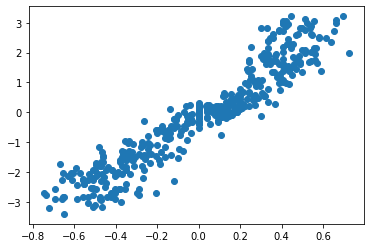

In [18]:
plt.plot(action_ratios, reward_ratios, marker='o', linestyle="None")

In [19]:
print(np.exp(action_ratios))

[0.89655172 0.84848485 0.88888889 1.5        1.32       0.53333333
 0.48888889 0.76470588 1.47368421 1.14285714 0.83870968 1.4
 1.4        0.93939394 1.55555556 0.7        0.72727273 0.62068966
 1.26666667 0.54166667 1.61538462 1.31578947 0.68571429 1.14814815
 1.8        1.7826087  1.1        0.575      0.71428571 1.77777778
 1.71428571 0.48484848 1.24       1.23529412 1.29166667 1.5
 0.88888889 1.         0.81481481 1.35       1.39130435 0.66666667
 1.66666667 1.14285714 1.         1.66666667 1.14285714 0.67857143
 1.54545455 0.96428571 0.81818182 0.66666667 1.46153846 0.68421053
 0.5862069  1.52631579 1.44444444 1.54545455 0.6875     0.58823529
 1.78571429 1.04       0.48       1.94117647 1.04347826 0.97058824
 1.76923077 0.8125     0.6        1.57142857 1.40909091 1.76190476
 1.5        1.61904762 1.5        1.31034483 1.4        0.52173913
 1.5        0.73076923 1.6        0.62068966 1.53333333 1.12
 0.70588235 0.54285714 1.04       1.57142857 1.64705882 1.5
 0.9375     1.58333333